In [1]:
import poppy
import copy
import pickle
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from skimage.transform import resize

%matplotlib inline

In [2]:
## BEGIN USER-DEFINED QUANTITIES

# initial focal length of lens (um) in the substrate
f_lens_substr = 284.664*u.micron
f_lens = f_lens_substr

# pixel scale of 'detector' (plane of waveguide entrance)
scale_wg = 0.2161*u.micron/u.pix

# lenslet diameter
diam_lenslet = 66.*u.micron

# index of refraction of substrate
n_glass = 1.5255

## LOOP THIS
# wavelength in air (n = 1)
wavel_air = 1.55*u.micron

## END USER-DEFINED QUANTITIES

In [3]:
# derived quantities

# wavelength in substrate
wavel_substr = (wavel_air/n_glass)
wavel = wavel_substr

# radius of first dark ring in um
circ_r_um = 1.22 * wavel_substr * f_lens_substr/diam_lenslet

print('radius of first dark Airy ring (um):',circ_r_um)

radius of first dark Airy ring (um): 5.346479783081552 micron


In [4]:
# read in waveguide mode

'''
S. Gross:

The waveguide modes have a 4sigma diameter of 8.3x7.6um. 
A simple Gaussian fit gives a 1/e2 diameter of 5.8x5.4um. 
Both at a wavelength of 1550nm.

The attached CSV file contains the corresponding intensity profile. 
The scale is 0.2161um per pixel.
'''

# retrieve waveguide intensity and make cutout
stem = '/Users/bandari/Documents/git.repos/glint_misc/notebooks/data/'
open_file = open(stem + 'waveguide_intensity.pkl', "rb")
df_intensity, xycen = pickle.load(open_file)
open_file.close()
# cutouts
buffer = 100 # pix
waveguide_cutout = df_intensity[int(xycen[1]-buffer):int(xycen[1]+buffer),int(xycen[0]-buffer):int(xycen[0]+buffer)]

In [5]:
# physical dims of waveguide pattern

x_dim_waveguide, y_dim_waveguide = np.multiply(np.shape(waveguide_cutout),scale_wg*u.pixel)

In [6]:
x_dim_waveguide

<Quantity 43.22 micron>

In [7]:
np.shape(waveguide_cutout)

(200, 200)

In [8]:
# physical scale of propagated wavefront compared to waveguide mode
# (i.e., a scale > 1 means propagated wavefront is coarser ('smaller') than the waveguide mode)

'''
scale_wf_2_wg = (wf_2.pixelscale.to(u.micron/u.pix))/scale_wg
'''

'\nscale_wf_2_wg = (wf_2.pixelscale.to(u.micron/u.pix))/scale_wg\n'

(<Axes: title={'center': 'Wavefront amplitude'}, xlabel='m', ylabel='m'>,
 <Axes: title={'center': 'Wavefront phase'}, xlabel='m'>)

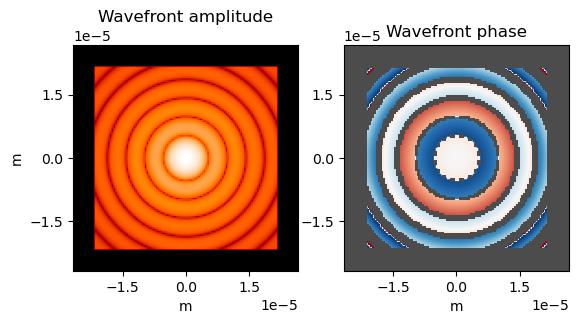

In [44]:
# construct Fresnel system with lens of focal length f um and project image

npix = 512 # ~512 is minimum to accurately recover the central diffraction spike

## LOOP THIS
z = f_lens # propagation distance

wf = poppy.FresnelWavefront(beam_radius=0.5*diam_lenslet, wavelength=wavel, npix=npix, oversample=10)
wf *= poppy.CircularAperture(radius=0.5*diam_lenslet) 

conv_lens = poppy.QuadraticLens(f_lens=f_lens)
wf *= conv_lens

# propagate over distance z
wf.propagate_fresnel(z)

# wavefront on MLA
wf_1 = copy.deepcopy(wf)

#det = osys_circ.add_detector(pixelscale=pixelscale_ang, fov_pixels=100)

# crop to the physical size of the waveguide cutout
wf *= poppy.RectangleAperture(width=x_dim_waveguide, height=y_dim_waveguide)
# remove residual zeros on edges
x, y = np.nonzero(wf.amplitude)
xl,xr = x.min(),x.max()
yl,yr = y.min(),y.max()
wf_amp_cropped = wf.amplitude[xl:xr+1, yl:yr+1]
wf_phase_cropped = wf.phase[xl:xr+1, yl:yr+1]

#wf_2 = copy.deepcopy(wf)

wf.display('both', scale='log', 
           vmax=wf.amplitude.max(), vmin=wf.amplitude.max()*1e-5, 
           imagecrop=10.*circ_r_um)


In [29]:
scale_wg

<Quantity 0.2161 micron / pix>

In [63]:
# ratio of wf spatial scale to waveguide scale

scale_wf = wf_2.pixelscale.to(u.micron/u.pix)

scale_wf_2_wg = scale_wf/scale_wg

print('spatial scale_wf',scale_wf)
print('spatial scale_wg',scale_wg)

spatial scale_wf 0.4351260246441879 micron / pix
spatial scale_wg 0.2161 micron / pix


In [64]:
# rescale image of waveguide mode 

In [65]:
scale_wf_2_wg = scale_wf/scale_wg

In [70]:
scale_wf_2_wg

<Quantity 2.01354014>

In [71]:
new_shape_wavefront = np.array(np.shape(wf_amp_cropped)*scale_wf_2_wg).astype(int)

In [69]:
np.shape(wf_amp_cropped)

(99, 99)

In [72]:
new_shape_wavefront

array([199, 199])

In [51]:
# what should shape of the waveguide mode be?

type(scale_wf_2_wg*np.shape(wf.amplitude))

astropy.units.quantity.Quantity

In [73]:
# rescale wavefront by this much 

wf_amp_rescaled = resize(wf_amp_cropped,np.shape(waveguide_cutout)) #scale_wf_2_wg*np.shape(wf_2.amplitude))

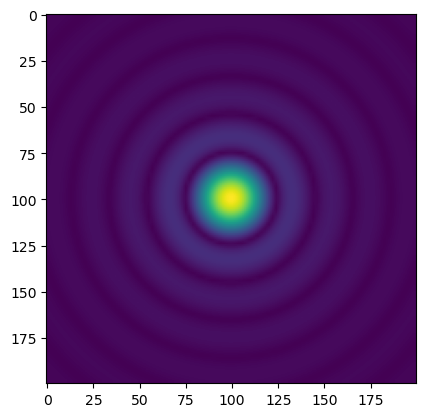

In [74]:
plt.imshow(wf_amp_rescaled)
plt.show()

In [27]:
plt.imshow(wf_amp_rescaled)
plt.show()

In [25]:
scale_wf_2_wg*np.shape(wf_2.amplitude)

<Quantity [20443.93038602, 20443.93038602]>

In [13]:
test = wf_2.amplitude[~np.all( wf_2.amplitude == 0, axis=1 )]


In [14]:
np.shape(test)

(41, 4096)

In [64]:
test2 = test[~np.all( test == 0, axis=1 )]

In [ ]:
~np.all(OriginMat == 0, axis = 0)

In [66]:
plt.imshow(test2)
plt.show()

In [ ]:
wf_2.display('amplitude', scale='log', 
           vmax=wf.amplitude.max(), vmin=wf.amplitude.max()*1e-5)

In [35]:
wf.amplitude

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# -----------------------------------------------------

In [46]:
# for secondary physical axes: 0.2161um per pixel.
def pix2um(x):
    return x*0.2161

def um2pix(x):
    return x/0.2161

# radius of first dark ring in um
wavel = 1.55/1.5255 # um # 1.55 um in air, 1.55um/n = 1.55um/1.5255 = 1.016 um in substrate of index of refraction n
foc_length = 284.664 # 
D = 66 # um

circ_r_um = 1.22 * wavel * foc_length/D
circ_r_pix = um2pix(circ_r_um)

In [47]:
circ_cen_x = 0
circ_cen_y = 0 
circ1 = Circle((circ_cen_x,circ_cen_y),radius=circ_r_pix,color='white',fill=False)

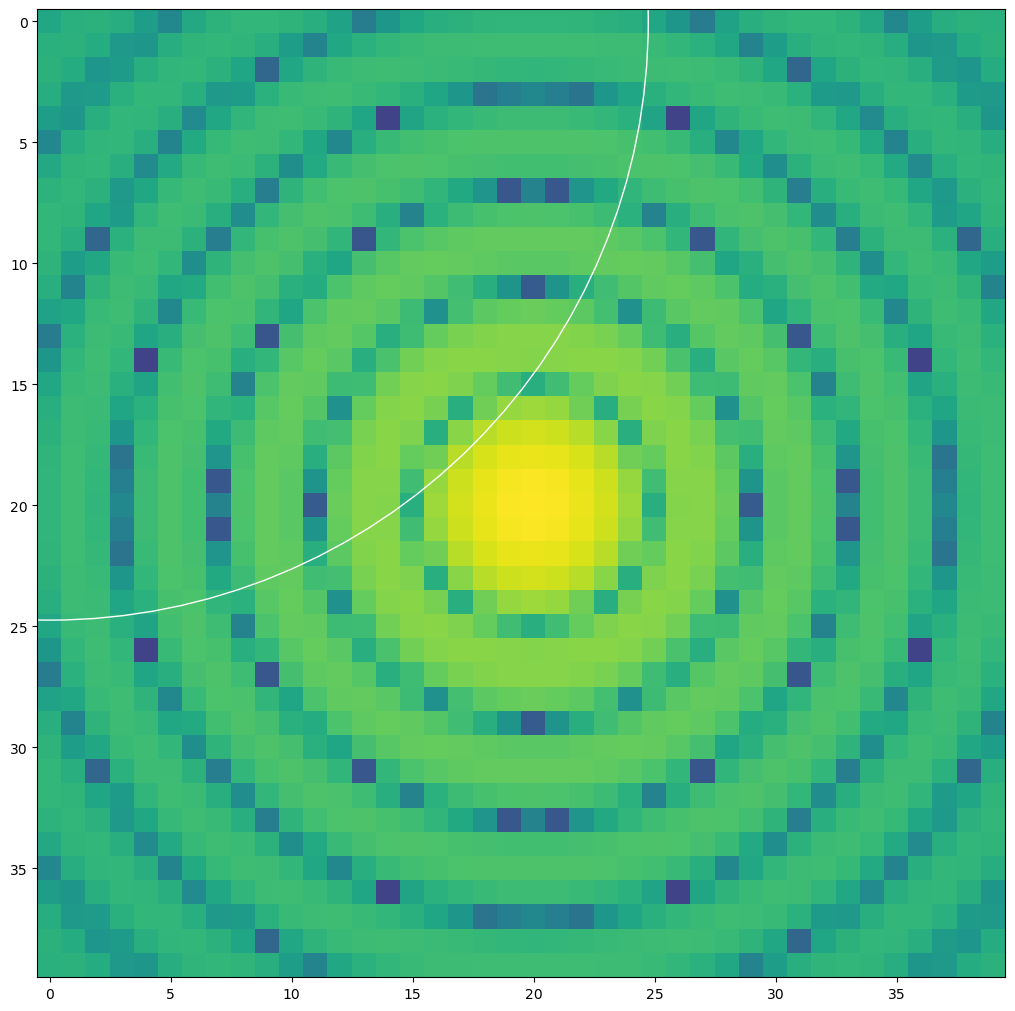

In [48]:
buffer = 20

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10), layout='constrained')
ax.imshow(wf.amplitude[int(0.5*np.shape(wf.amplitude)[0]-buffer):int(0.5*np.shape(wf.amplitude)[0]+buffer),
                       int(0.5*np.shape(wf.amplitude)[0]-buffer):int(0.5*np.shape(wf.amplitude)[0]+buffer)], 
           norm='log', 
           vmax=wf.amplitude.max(), vmin=wf.amplitude.max()*1e-5)
ax.add_patch(circ1)
plt.show()

In [39]:
int(0.5*np.shape(wf.amplitude)[0]-buffer)

1948

In [ ]:
#circ3 = Circle((circ_cen_x,circ_cen_y),radius=circ_r_pix,color='white',fill=False)

In [3]:
# construct system
osys_circ = poppy.OpticalSystem()

# lenslet
lens = osys_circ.add_pupil(optic = poppy.ThinLens(name='lenslet', nwaves=0, radius=diam_lenslet))

# final focal plane
det = osys_circ.add_detector(pixelscale=pixelscale_ang, fov_pixels=100)  # image plane coordinates in arcseconds
#psf = osys_circ.calc_psf(wavelength=1.550*u.micron)

# see transmittance
#osys_circ.display()

#poppy.display_psf(psf)

psf, all_wfs = osys_circ.calc_psf(wavelength=1.550*u.micron, 
                         display_intermediates=False,
                         return_intermediates=True)

NameError: name 'diam_lenslet' is not defined